In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
!pip install normflows nflows einops ipdb torchsde torchdiffeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 11.2 MB/s eta 0:00:00
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87246 sha256=7277154f5e01a8b1666a331af875b0631738ae053983215cf00c3a3cf6f9f330
  Stored in directory: /home/ray/.cache/pip/wheels/34/b2/f3/e97b5a749e1b93adfdca027b9050d0ee4d4790c5a5dec45a6d
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53653 sha256=53f2ace74ca01ce1c2e8493058107a738dfde68c2a67f7ad4d9cabb7573ec745
  Stored in directory: /home/ray/.cache/pip/wheels/3b/88/52/cbd4ed0597b48916de3de19b28d7297c72595f56085068c772
Successfully built normflows nflows

[notice] A new release of pip

In [2]:
!pip install torch==2.0.1+cu118 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 458.7 kB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 32.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+rocm5.6
    Uninstalling torch-2.1.0+rocm5.6:
      Successfully uninstalled torch-2.1.0+rocm5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.6.5 requires protobuf<=3.20.1, but you have protobuf 3.20.3 which is incompatible.
pytorch-lightning 1.6.5 requires PyYAML>=5.4, but you have pyyaml 5.3.1 which is incompatible.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 2.0.1+cu118 which is incompatible.
torchvision 0.14.0+cu116 requires torch==1.13.0, but you have torch 2.0.1+cu118 which is incompatible.

[notice] A new r

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import models.ddpm
import models.mlp
import pdb
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

import torch
import torchsde

from functorch import vmap

from torchdiffeq import odeint

In [4]:
import numpy as np
import torch
import torch as th
import torch.distributions as D

import abc
import torch
from torch.utils.data import Dataset


class BaseSet(abc.ABC, Dataset):
    def __init__(self, len_data=-2333):
        self.num_sample = len_data
        self.data = None
        self.data_ndim = None

    def gt_logz(self):
        raise NotImplementedError

    #@abc.abstractmethod
    def energy(self, x):
        return

    def unnorm_pdf(self, x):
        return torch.exp(-self.energy(x))

    # hmt stands for hamiltonian
    def hmt_energy(self, x):
        dim = x.shape[-1]
        x, v = torch.split(x, dim // 2, dim=-1)
        neg_log_p_x = self.sample_energy_fn(x)
        neg_log_p_v = nll_unit_gaussian(v)
        return neg_log_p_x + neg_log_p_v

    @property
    def ndim(self):
        return self.data_ndim

    def sample(self, batch_size):
        del batch_size
        raise NotImplementedError

    def score(self, x):
        with torch.no_grad():
            copy_x = x.detach().clone()
            copy_x.requires_grad = True
            with torch.enable_grad():
                self.energy(copy_x).sum().backward()
                lgv_data = copy_x.grad.data
            return lgv_data

    def hmt_score(self, x):
        with torch.no_grad():
            copy_x = x.detach().clone()
            copy_x.requires_grad = True
            with torch.enable_grad():
                self.hmt_energy(copy_x).sum().backward()
                lgv_data = copy_x.grad.data
            return lgv_data

    def ksd(self, points):
        with torch.no_grad():
            cur_ksd = self.gt_ksd()
        return self.worker(points) - cur_ksd

    def gt_ksd(self):
        if self._gt_ksd is None:
            with torch.no_grad():
                self._gt_ksd = self.worker(
                    self.sample(5000).view(5000, -1), adjust_beta=True
                )
        return self._gt_ksd

class FunnelSet(BaseSet):
    """
    x0 ~ N(0, 3^2), xi | x0 ~ N(0, exp(x0)), i = 1, ..., 9
    """
    def __init__(self, dim):
        super().__init__()
        self.data = th.ones(dim, dtype=float).cuda()
        self.data_ndim = dim

        self.dist_dominant = D.Normal(th.tensor([0.0]).cuda(), th.tensor([3.0]).cuda(), validate_args=False)
        self.mean_other = th.zeros(dim - 1).float().cuda()
        self.cov_eye = th.eye(dim - 1).float().cuda().view(1, dim - 1, dim - 1)

    # def cal_gt_big_z(self):
    #     return 1

    def gt_logz(self):
        return 0.

    def energy(self, x):
        return -self.funnel_log_pdf(x)

    def viz_pdf(self, fsave="density.png", lim=3):
        raise NotImplementedError

    def funnel_log_pdf(self, x):
        dominant_x = x[:, 0]
        log_density_dominant = self.dist_dominant.log_prob(dominant_x)  # (B, )
        # log_density_other = self._dist_other(dominant_x).log_prob(x[:, 1:])  # (B, )

        log_sigma = 0.5 * x[:, 0:1]
        sigma2 = torch.exp(x[:, 0:1])
        neglog_density_other = 0.5*np.log(2*np.pi) + log_sigma + 0.5 * x[:, 1:] ** 2 / sigma2
        log_density_other = torch.sum(-neglog_density_other, dim=-1)

        return log_density_dominant + log_density_other

    def sample(self, batch_size):
        dominant_x = self.dist_dominant.sample((batch_size,))  # (B,1)
        x_others = self._dist_other(dominant_x).sample()  # (B, dim-1)
        return th.hstack([dominant_x, x_others])

    def _dist_other(self, dominant_x):
        variance_other = th.exp(dominant_x)
        cov_other = variance_other.view(-1, 1, 1) * self.cov_eye
        # use covariance matrix, not std
        return D.multivariate_normal.MultivariateNormal(self.mean_other, cov_other)

## Cox Distribution

In [5]:
import itertools

import os.path as osp
import pathlib

import numpy as np
import pandas
import torch as th


# pylint: disable=invalid-name, too-many-instance-attributes
def read_points(file_path):
    df = pandas.read_csv(file_path)
    x_pos, y_pos = np.array(df["data_x"]), np.array(df["data_y"])
    pos = np.vstack([x_pos, y_pos]).T  # (B, 2)
    return pos


def get_bin_counts(array_in, num_bins_per_dim):
    scaled_array = array_in * num_bins_per_dim
    counts = np.zeros((num_bins_per_dim, num_bins_per_dim))
    for elem in scaled_array:
        flt_row, col_row = np.floor(elem)
        row = int(flt_row)
        col = int(col_row)
        # Deal with the case where the point lies exactly on upper/rightmost edge.
        if row == num_bins_per_dim:
            row -= 1
        if col == num_bins_per_dim:
            col -= 1
        counts[row, col] += 1
    return counts


def get_bin_vals(num_bins: int):
    grid_indices = np.arange(num_bins)
    bin_vals = np.array(
        [np.array(elem) for elem in itertools.product(grid_indices, grid_indices)]
    )

    return bin_vals


def th_batch_kernel_fn(x, y, signal_variance, num_grid_per_dim, raw_length_scale):
    x = x.view(-1, 1, x.shape[-1])  # Bx1xL
    y = y.view(1, -1, x.shape[-1])  # 1xBxL
    dist = th.norm(x - y, dim=2) / (num_grid_per_dim * raw_length_scale)
    return signal_variance * th.exp(-dist)  # BxB


def get_latents_from_white(white, const_mean, cholesky_gram):
    """
    white: (B,D)
    const_mean: scalar
    cholesky_gram: (D,D)
    """
    return th.einsum("ij,bj->bi", cholesky_gram, white) + const_mean


def get_white_from_latents(latents, const_mean, cholesky_gram):
    """
    latents: (B,D)
    const_mean: scalar
    cholesky_gram: (D,D)
    """
    white = th.triangular_solve(
        latents.unsqueeze(-1) - const_mean, cholesky_gram, upper=False
    ).solution  # (B,D, 1)
    return white.squeeze(dim=-1)


def poisson_process_log_likelihood(latent_function, bin_area, flat_bin_counts):
    """
    latent_function: (B,D)
    bin_area: Scalar
    flat_bin_counts: (D)
    """
    first_term = latent_function * flat_bin_counts.unsqueeze(0)  # (B,D)
    second_term = -bin_area * th.exp(latent_function)
    return th.sum(first_term + second_term, dim=1)  # (B,)


class Cox:
    def __init__(self, file_name, num_bins_per_dim, use_whitened):
        self.use_whitened = use_whitened
        self._num_latents = num_bins_per_dim ** 2
        self._num_grid_per_dim = num_bins_per_dim
        bin_counts = np.array(get_bin_counts(read_points(file_name), num_bins_per_dim))

        self._flat_bin_counts = bin_counts.flatten()

        self._poisson_a = 1.0 / self._num_latents

        self._signal_variance = 1.91
        self._beta = 1.0 / 33

        # torch
        self._bin_vals = th.from_numpy(get_bin_vals(num_bins_per_dim)).cuda().float()

        short_kernel_func = lambda x, y: th_batch_kernel_fn(
            x, y, self._signal_variance, num_bins_per_dim, self._beta
        )
        self._gram_matrix = short_kernel_func(self._bin_vals, self._bin_vals)
        self._cholesky_gram = th.linalg.cholesky(self._gram_matrix)
        self._white_gaussian_log_normalizer = (
            -0.5 * self._num_latents * np.log(2.0 * np.pi)
        )  # float

        half_log_det_gram = th.sum(th.log(th.abs(th.diag(self._cholesky_gram))))
        self._unwhitened_gaussian_log_normalizer = (
            -0.5 * self._num_latents * np.log(2.0 * np.pi) - half_log_det_gram
        )  # tensor scalar

        self._mu_zero = np.log(126.0) - 0.5 * self._signal_variance  # tensor scalar

        self._flat_bin_counts = th.from_numpy(self._flat_bin_counts).cuda().float()

        if use_whitened:
            self.evaluate_log_density = self.whitened_posterior_log_density
        else:
            self.evaluate_log_density = self.unwhitened_posterior_log_density

    def whitened_posterior_log_density(self, white):
        # B, _ = white.shape
        quadratic_term = -0.5 * th.sum(white ** 2, dim=1)  # (B,)
        prior_log_density = self._white_gaussian_log_normalizer + quadratic_term  # (B,)
        latent_function = get_latents_from_white(
            white, self._mu_zero, self._cholesky_gram
        )  # (B,D)
        log_likelihood = poisson_process_log_likelihood(
            latent_function, self._poisson_a, self._flat_bin_counts
        )  # (B,)
        return prior_log_density + log_likelihood  # (B,)

    def unwhitened_posterior_log_density(self, latents):
        white = get_white_from_latents(
            latents, self._mu_zero, self._cholesky_gram
        )  # (B,D)
        prior_log_density = (
            -0.5 * th.sum(white * white, dim=1)
            + self._unwhitened_gaussian_log_normalizer
        )  # (B,)
        log_likelihood = poisson_process_log_likelihood(
            latents, self._poisson_a, self._flat_bin_counts
        )  # (B,)
        return prior_log_density + log_likelihood
    

class CoxDist(BaseSet):
    def __init__(self, len_data, dim, is_linear=True):
        fcsv = "df_pines.csv"
        self.cox = Cox(fcsv, 40, use_whitened=False)

        super().__init__(len_data)
        self.data = th.ones(dim, dtype=float).cuda()  # pylint: disable= not-callable
        self.data_ndim = dim
        
    def log_pdf(self, x):
        return self.cox.evaluate_log_density(x)

    def get_gt_disc(self, x):
        return -self.cox.evaluate_log_density(x)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Function Definitions

### Estimated Reward Functions

In [99]:
# calculate the log expectation of the reward
def log_E_R(
    _x, _t, beta, num_mc_samples, global_mins=-50, global_maxs=50, var_exploding=True
):
    h_t = beta * _t.repeat_interleave(num_mc_samples).unsqueeze(1)
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t = beta * repeated_t
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t**0.5)
        log_rewards = target.log_pdf(samples) #unnormalize(samples, global_mins, global_maxs)
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    else:
        # variance preserving
        samples = (repeated_x / torch.sqrt(1 - repeated_t.unsqueeze(1)) 
                   + torch.randn(repeated_x.shape).to(device) * (h_t**0.5))
        log_rewards = target.energy(samples) #unnormalize(samples, global_mins, global_maxs)
        log_expectation_R = (
            torch.log(1 / (1 - _t))
            + torch.logsumexp(log_rewards, dim=-1)
            - np.log(num_mc_samples)
        )
    return log_expectation_R

In [89]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, randomness="different", in_dims=(0, 0, None, None))(
        x, t, beta, num_mc_samples, var_exploding=var_exploding
    )

In [90]:
# def estimate_grad_Rt(x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False):
#     t = t * torch.ones(x.shape[0]).to(device)
#     est_scores_n = torch.vmap(torch.func.grad(log_E_R),
#                             in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples,
#                                                                                   var_exploding=var_exploding)
#     if richardson:
#         est_scores_n_div2 = torch.vmap(torch.func.grad(log_E_R),
#                                    in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples//2,
#                                                                                          var_exploding=var_exploding)
#         return (2*est_scores_n - est_scores_n_div2)
#     else:
#         return est_scores_n

In [91]:
def estimate_grad_Rt(
    x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False
):
    est_scores = torch.func.grad(log_E_R)(
        x, t, beta, num_mc_samples, var_exploding=var_exploding
    )
    
    norm = torch.linalg.vector_norm(est_scores, dim=-1)
    max_norm = 100
    clip_coeff = torch.clamp(max_norm / (norm+1e-6), max=1)
    clipped_f = est_scores * clip_coeff.unsqueeze(-1)
    
    return clipped_f#.clamp(min=-100.0, max=100.0)
    
    if richardson:
        est_scores_n_div2 = torch.func.grad(log_E_R)(
            x, t, beta, num_mc_samples // 2, var_exploding=var_exploding
        )
        return 2 * est_scores_n - est_scores_n_div2
    else:
        return est_scores_n

### True Reward Functions

In [11]:
def true_Rt(x, t, beta, global_mins=-50, global_maxs=50, var_exploding=True):
    h_t = beta * t
    # target.convolve(h_t * (global_maxs**2), t, var_exploding=var_exploding)
    target.convolve(h_t, t, var_exploding=var_exploding)
    energy = target.log_prob(unnormalize(x, global_mins, global_maxs))
    target.reset()
    return energy

In [12]:
def true_grad_Rt(x, t, beta, var_exploding=True):
    samples_energy = true_Rt(x, t, beta, var_exploding=var_exploding)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores

## SDE Tests

### VE SDE

In [13]:
class VEReverseSDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta

    def f(self, t, x):
        with torch.enable_grad():
            x.requires_grad = True
            score = torch.vmap(self.score, in_dims=(0, None, None), randomness="different")(x, (1-t).to(device), self.beta)
            # score = self.score(x, (1 - t).to(device), self.beta)
        return self.g(t, x) ** 2 * score

    def g(self, t, x):
        return torch.full_like(x, self.beta**0.5)

In [14]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    drift = sde.f(t, x) * dt
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    vectors = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            vectors.append(f)
    return torch.stack(samples), torch.stack(vectors)

In [15]:
def generate_samples(ve_reverse_sde, x_init):
    t = torch.linspace(0.001, 1.0, 500)
    with torch.no_grad():
        samples = torchsde.sdeint(ve_reverse_sde, x_init, t)
    return samples

In [16]:
target = CoxDist(10, 1600)
beta = 5.0
ve_reverse_sde = VEReverseSDE(estimate_grad_Rt, beta)

In [256]:
true_samples = target.sample(500)

NotImplementedError: 

In [259]:
big_samples = true_samples[true_samples[:, 0].abs() > 6.0]

In [199]:
big_samples

tensor([[ 6.3354e+00,  6.4944e+00,  4.9774e+01,  1.8465e+01, -1.4086e+00,
          2.5991e+01, -1.1644e+01,  5.8474e+01,  2.4121e+01, -8.6196e+00],
        [ 7.8043e+00, -1.3247e+01,  5.9576e+01,  9.9384e+01,  3.1198e+01,
         -2.3818e+01,  2.9590e+01, -1.3662e+01,  1.8508e+01, -1.3834e+02],
        [-6.3616e+00,  3.9337e-02,  4.0715e-02,  3.7902e-02, -2.5204e-02,
          2.8861e-02,  6.7625e-02,  7.5044e-02, -4.8851e-02,  3.5435e-03],
        [ 8.3153e+00, -1.0358e+02, -5.0843e+01, -5.6876e+01, -7.1380e+01,
         -7.0359e+01,  9.1338e+01, -5.2372e+01, -3.5654e+01,  7.8009e+01],
        [-8.3499e+00,  9.5174e-03,  7.2659e-03,  2.9247e-02, -1.2537e-02,
          1.2669e-02,  2.1337e-02,  4.0123e-03, -2.3472e-02, -4.0969e-03],
        [-6.5825e+00,  2.9423e-02, -3.0002e-02, -1.4900e-02,  2.1148e-02,
         -6.2188e-03,  2.5543e-02,  1.6498e-02,  9.8618e-03, -5.2912e-02],
        [ 8.1937e+00,  5.5649e+01,  1.1414e+01, -7.6091e+00, -7.7539e+01,
          7.1086e+00, -3.8209e+0

In [78]:
num_samples = 5
dim = 1600

all_samples, all_vecs = [], []
for _ in tqdm(range(20)):
    x1_samples = torch.randn((num_samples, dim), device=device) * np.sqrt(beta)
    samples, vecs = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 1e-2)
    all_samples.append(samples)
    all_vecs.append(all_vecs)

100%|██████████| 20/20 [02:33<00:00,  7.68s/it]


In [98]:
samples = torch.cat([samp[-1] for samp in all_samples], dim=0)

In [282]:
target.log_pdf(samples[-1])

tensor([-2115.1245, -2115.7468, -2125.6816, -2102.1743, -2066.3733, -2155.2166,
        -2135.1587, -2147.7104, -2090.5908, -2081.9136], device='cuda:0',
       grad_fn=<AddBackward0>)

In [182]:
fin_samples = samples[-1]

In [183]:
fin_samples[fin_samples[:, 0].abs() > 6.0]

tensor([[ -6.2848,  -5.4884,  -3.1153,  -1.3797,  -0.2164,  -4.4922,  -2.3252,
          -3.6061,  -1.6835,   1.2989],
        [  6.2325,  -4.1983,  -0.0367,  -0.1560,   3.8111,   1.9779,   2.0919,
          -0.3896,   1.0932,   5.5732],
        [ -7.6559,   1.8584,   1.7641,   2.2637,   0.5185,  -2.1527,   2.1430,
          -1.4624,  -1.1321,  -2.7752],
        [ -7.2979,   0.0278,   2.9458,  -1.9493,  -3.4463,   3.8719,  -4.5685,
           0.9758,  -1.0286,   1.3357],
        [  7.8724,  -1.6323,  -1.5891,  -1.3997,   1.8201,   0.3730,  -2.1526,
           0.3372,  -0.6887,   0.9782],
        [ -8.9511,  -0.8304,  -0.7811,  -6.9331,   4.2328,  -1.9200,  -3.5072,
           0.7246,   1.5437,  -1.9653],
        [ -6.8730,  -0.0756,  -2.6206,   2.3687,   6.1354,   0.7583,   0.9689,
           1.9103,   0.7867,  -0.7912],
        [ -6.7378,   0.5856,  -1.9513,   4.8665,   4.2191,   2.8486,   1.4206,
           3.2429,   2.7677,   4.7539],
        [ -6.1166,   2.5018,  -0.9627,  -0.2854,

In [92]:
def drift(x, t):
    with torch.enable_grad():
        x.requires_grad = True
        if follow_estimate:
            f = -0.5 * beta * estimate_grad_Rt(x, t, beta, num_mc_samples=100)
            norm = torch.linalg.vector_norm(f, dim=-1)
            #print(norm.max())
            max_norm = 200
            clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
            f = f * clip_coef.unsqueeze(-1)
        else:
            f = - 0.5 * beta * true_grad_Rt(x, t, beta)
        
    return f

def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = torch.func.jacrev(u)
    return lambda x: torch.trace(J(x))

def get_div_fn_hutchinson(u):
    def _div_fn(x):
        epsilon = torch.randn_like(x)
        with torch.enable_grad():
            grad_fxn = lambda v: torch.sum(u(v) * epsilon)
            grad_score_e = torch.func.grad(grad_fxn)(x)
            
        return torch.sum(grad_score_e * epsilon, dim=-1)    
  
    return _div_fn

def output_and_div(vecfield, x):
    hutchinson_div_fn = get_div_fn_hutchinson(vecfield)
    if follow_estimate:
        dx = torch.vmap(vecfield, randomness="different")(x)
        div = torch.vmap(hutchinson_div_fn, randomness="different")(x)
    else:
        dx = vecfield(x)
        div = torch.vmap(div_fn(vecfield), randomness="different")(x.clone().detach().requires_grad_(True))
    return dx, div

def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)
    vecfield = lambda x: drift(x, t)
    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)

def prior_dist(beta, dim=1):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(dim).to(device), 
        torch.eye(dim).to(device) * beta, 
        validate_args=False
        )
    return dist

In [102]:
import gc
torch.cuda.empty_cache()
gc.collect()

3905

In [ ]:
reverse_time = False
follow_estimate = True

all_p1 = []
for i in tqdm(range(20)):
    with torch.no_grad():
        if reverse_time:
            x1 = torch.randn(1024, 2).to(device) * sigma
            time = torch.linspace(1, 0, 1000).to(device)
        else:
            x1 = samples[i * 5 : (i + 1) * 5]
            time = torch.linspace(0, 1, 1000).to(device)
        state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
        state1.requires_grad = True
        state0 = odeint(odefunc, state1, t=time, method="euler")[-1]

        x0, logdetjac = state0[..., :-1], state0[..., -1]
        p0 = prior_dist(beta, dim)
        logp0 = p0.log_prob(x0)
        all_p1.append((logp0 + logdetjac).detach().cpu())

 25%|██▌       | 5/20 [18:33<55:41, 222.79s/it]  

In [67]:
logp1 = torch.cat([logp1, logp1_new])

In [68]:
rewards = target.log_pdf(samples[-1])

In [71]:
logZ_estimate = torch.logsumexp(rewards - logp1, dim=0) - np.log(10)

In [75]:
(rewards - logp1)

tensor([493.1050, 461.6702, 672.3225, 569.1643, 520.5649, 440.1914, 516.0251,
        489.5991, 514.9329, 507.7529], device='cuda:0', grad_fn=<SubBackward0>)

In [82]:
(rewards - logp1).mean()

tensor(518.5328, device='cuda:0', grad_fn=<MeanBackward0>)

In [74]:
(rewards - logp1).std()

tensor(64.2987, device='cuda:0', grad_fn=<StdBackward0>)

In [72]:
logZ_estimate

tensor(670.0199, device='cuda:0', grad_fn=<SubBackward0>)

In [297]:
num_samples = 400
sigma = 31
beta = sigma**2

target.convolve(torch.tensor(1000, device=torch.device("cpu")), 1)
x1_samples = target.sample((num_samples,))
target.reset()
x1_samples_normalized = normalize(x1_samples)[0]

AttributeError: 'CoxDist' object has no attribute 'convolve'

In [53]:
vecs_norm = torch.linalg.vector_norm(vecs, dim=-1)

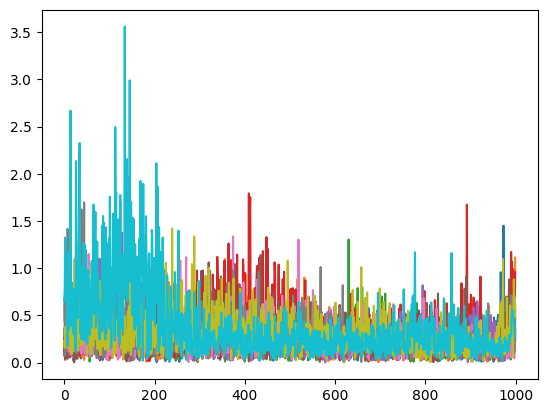

In [54]:
plt.plot(vecs_norm.cpu().numpy()[:, :10])

In [47]:
# ve_reverse_sde = VEReverseSDE(true_grad_Rt, beta)
ve_reverse_sde = VEReverseSDE(estimate_grad_Rt, beta)
#samples = generate_samples(ve_reverse_sde, x1_samples_normalized)
samples, vecs = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 1e-3)

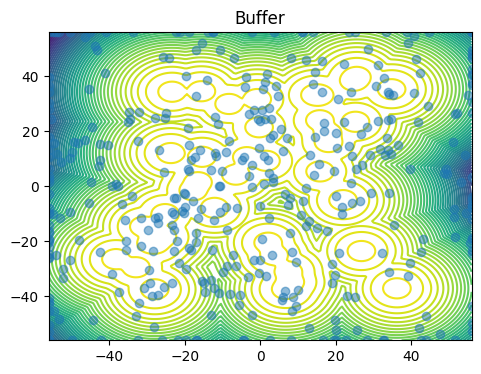

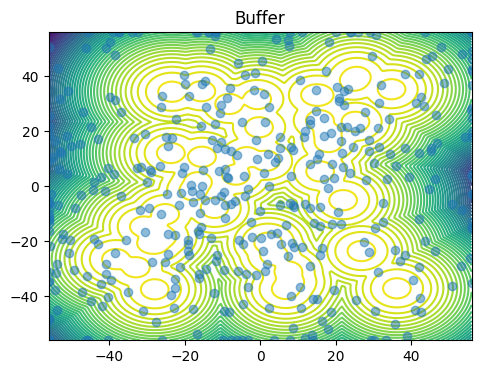

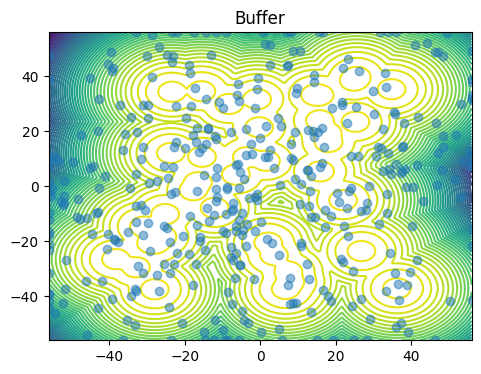

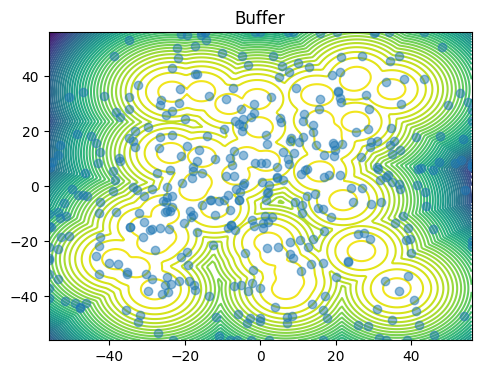

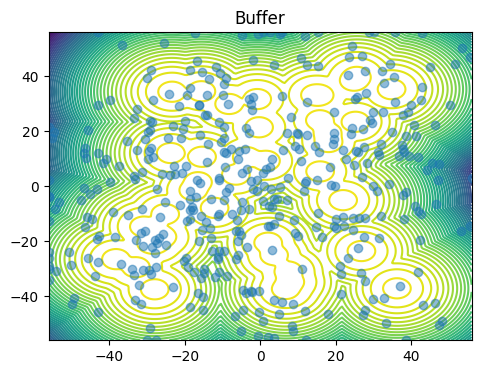

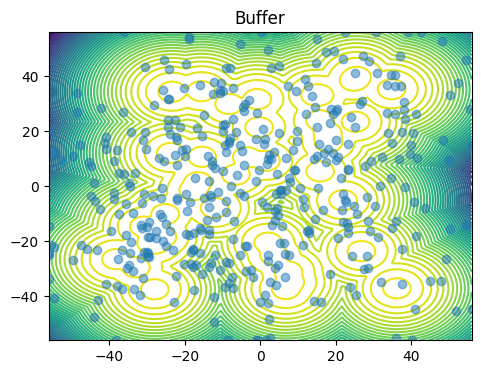

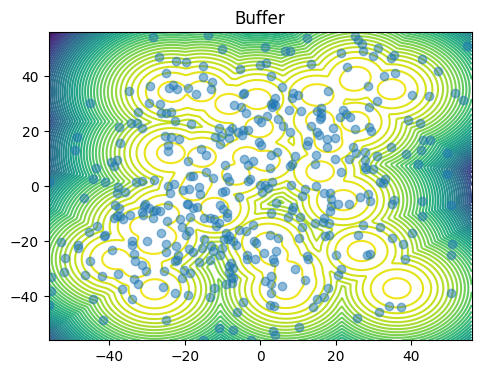

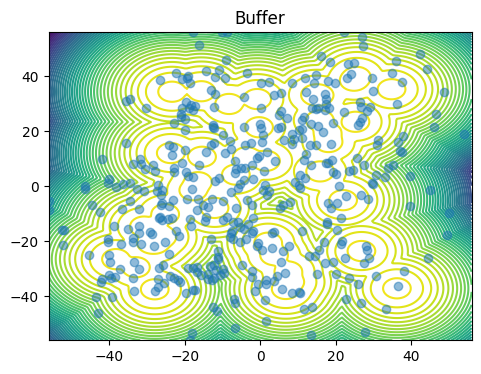

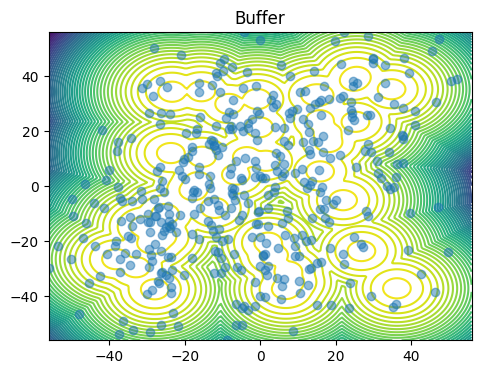

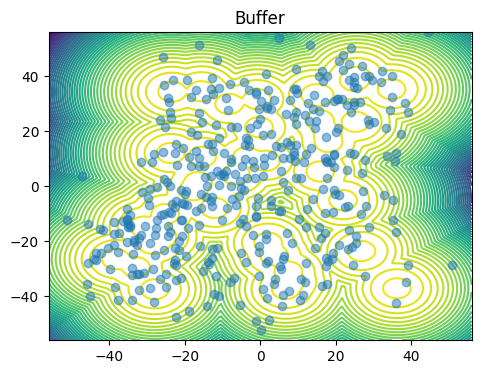

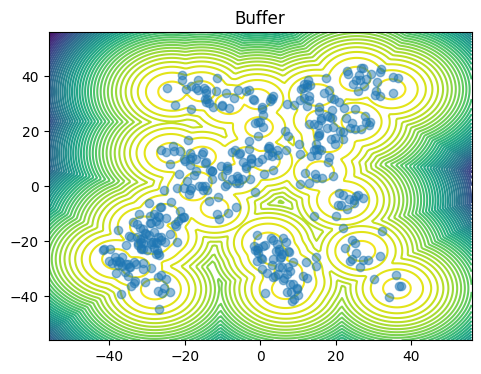

In [44]:
for i in range(0, len(samples), 99):
    plot_dataset(unnormalize(samples[i], global_mins_init, global_maxs_init))

In [33]:
from torch.func import jacrev

In [34]:
def true_Rt(x, t, beta, global_mins=-50, global_maxs=50, var_exploding=True):
    h_t = beta * t
    target.convolve(h_t, t, var_exploding=var_exploding)
    energy = target.log_prob(x)
    target.reset()
    return energy

def true_grad_Rt(x, t, beta, var_exploding=True):
    with torch.enable_grad():
        samples_energy = true_Rt(x, t, beta, var_exploding=var_exploding)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, create_graph=True)[0]
    return true_scores

In [35]:
def drift(x, t):
    with torch.enable_grad():
        x.requires_grad = True
        if follow_estimate:
            f = -0.5 * beta * estimate_grad_Rt(x, t, beta, num_mc_samples=100)
            norm = torch.linalg.vector_norm(f, dim=-1)
            #print(norm.max())
            max_norm = 200
            clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
            f = f * clip_coef.unsqueeze(-1)
        else:
            f = - 0.5 * beta * true_grad_Rt(x, t, beta)
        
    return f

In [36]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    return lambda x: torch.trace(J(x))

def output_and_div(vecfield, x):
    if follow_estimate:
        dx = torch.vmap(vecfield, randomness="different")(x)
        div = torch.vmap(div_fn(vecfield), randomness="different")(x)
    else:
        dx = vecfield(x)
        div = torch.vmap(div_fn(vecfield), randomness="different")(x.clone().detach().requires_grad_(True))
    return dx, div

In [37]:
def prior_dist(beta):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(2).to(device), torch.eye(2).to(device) * beta
    )
    return dist

In [38]:
sigma = 30
beta = sigma **2

In [49]:
follow_estimate = True
reverse_time = False

In [50]:
def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)
    vecfield = lambda x: drift(x, t)
    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)


batch_size = 10
num_batches = math.ceil(len(samples) / float(batch_size))

all_logp1, all_logp0 = [], []
for i in tqdm(range(num_batches)):
    with torch.no_grad():
        x1 = samples[i * batch_size : (i + 1) * batch_size]
        if reverse_time:
            #x1 = torch.randn(1024, 2).to(device) * sigma
            time = torch.linspace(1, 0, 1000).to(device)
        else:
            #x1 = unnorm_true_samples
            time = torch.linspace(0, 1, 1000).to(device)
        state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
        state1.requires_grad = True
        state0 = odeint(odefunc, state1, t=time, method="euler")[-1]

        x0, logdetjac = state0[..., :-1], state0[..., -1]
        p0 = prior_dist(beta)
        logp0 = p0.log_prob(x0)
        logp1 = -(logp0 + logdetjac)
        
        all_logp1.append(logp1.detach().cpu())
        all_logp0.append(logp0.detach().cpu())

In [41]:
p0 = prior_dist(beta)
logp0 = p0.log_prob(x0)
logp1 = -(logp0 + logdetjac)

In [43]:
print("logp0", logp0.mean())
print("logdetjac", logdetjac.mean())
print("logp1", logp1.mean())


logp0 tensor(-9.9718, device='cuda:0')
logdetjac tensor(2.8784, device='cuda:0')
logp1 tensor(7.0934, device='cuda:0')


In [44]:
log_p0_true = true_Rt(x0, torch.tensor(1).to(device), beta)
(logp0 - log_p0_true).mean()

tensor(-0.0532, device='cuda:0')

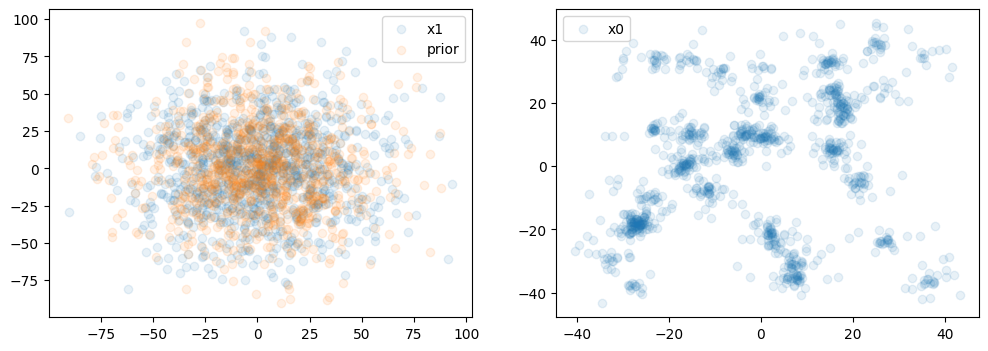

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(x1[:, 0].detach().cpu(), x1[:, 1].detach().cpu(), alpha=0.1, label="x1")

prior_samples = p0.sample((1000,))
if reverse_time:
    ax[0].scatter(prior_samples[:, 0].detach().cpu(), prior_samples[:, 1].detach().cpu(), alpha=0.1, label="prior")
else:
    ax[1].scatter(prior_samples[:, 0].detach().cpu(), prior_samples[:, 1].detach().cpu(), alpha=0.1, label="prior")
ax[0].legend()

ax[1].scatter(x0[:, 0].detach().cpu(), x0[:, 1].detach().cpu(), alpha=0.1, label="x0")
ax[1].legend()
plt.show()

### VP SDE

In [ ]:
class VEReverseSDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta

    def f(self, t, x):
        with torch.enable_grad():
            x.requires_grad = True
            score = self.score(x, 1 - t, self.beta)
        return self.g(t, x) ** 2 * score

    def g(self, t, x):
        return torch.full_like(x, self.beta**0.5)

In [248]:
dim = 1

In [249]:
p1 = torch.distributions.MultivariateNormal(torch.zeros(dim).to(device)  , torch.eye(dim).to(device))  
x1 = p1.sample((1000,)).to(device)
x1.requires_grad = True

In [255]:
def grad_log_prob(x, t, beta):
    with torch.enable_grad():
        x = x.clone().detach()
        x.requires_grad = True
        pt = torch.distributions.MultivariateNormal(torch.zeros(dim).to(device), (torch.eye(dim).to(device) * torch.sqrt(beta * t) + torch.eye(dim).to(device))**2)
        logpt = pt.log_prob(x)
    return torch.autograd.grad(logpt.sum(), x, retain_graph=True)[0]

def f(x, t, beta):
    -beta * 0.5 * grad_log_prob(x, t, beta)

In [258]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    return lambda x: torch.trace(J(x))

def output_and_div(vecfield, x):
    dx = vecfield(x)
    return dx, torch.vmap(div_fn(vecfield), randomness="different")(x.clone().detach().requires_grad_(True))

In [257]:
def odefunc(t, x):
    beta=10
    t = t.to(device)
    vfield = lambda x: f(x, t, beta)
    dx, div = output_and_div(vfield, x)
    return -beta * 0.5 * dx

# with torch.no_grad():
x0 = odeint(odefunc, x1, t=torch.linspace(0.01, 0.99, 10).to(device), method="euler")[-1]

RuntimeError: vmap: It looks like you're either (1) calling .item() on a Tensor or (2) attempting to use a Tensor in some data-dependent control flow or (3) encountering this error in PyTorch internals. For (1): we don't support vmap over calling .item() on a Tensor, please try to rewrite what you're doing with other operations. For (2): If you're doing some control flow instead, we don't support that yet, please shout over at https://github.com/pytorch/functorch/issues/257 . For (3): please file an issue.

In [289]:
import seaborn as sns

<Axes: xlabel='None', ylabel='None'>

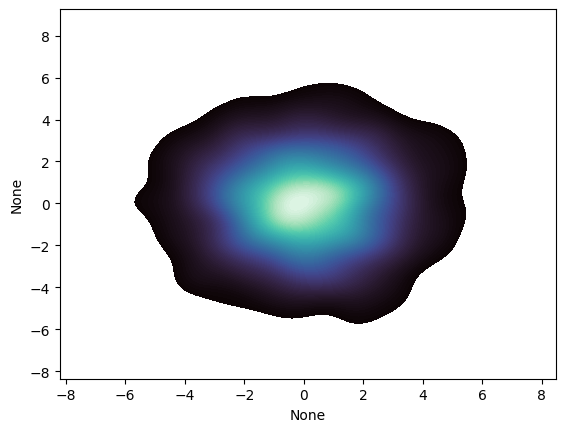

In [295]:
sns.kdeplot(x = x0[:,0].detach().cpu(), y = x0[:,1].detach().cpu(), fill=True, cmap="mako", thresh=0.05, levels=100)

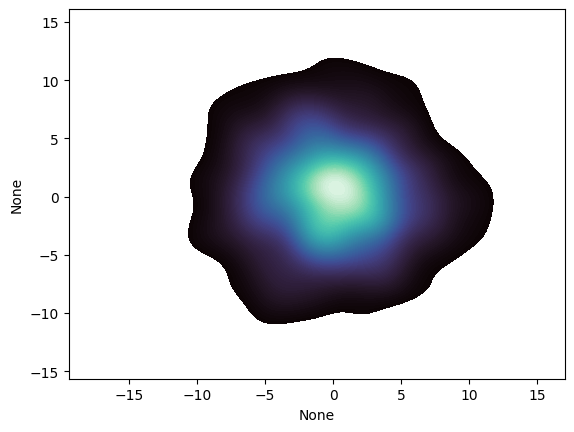

In [296]:
p0 = torch.distributions.MultivariateNormal(torch.zeros(2).to(device) , (torch.eye(2).to(device) + torch.eye(2).to(device) * np.sqrt(10))**2 )  
x0_true = p0.sample((1000,)).to(device)

sns.kdeplot(x = x0_true[:,0].detach().cpu(), y = x0_true[:,1].detach().cpu(), fill=True, cmap="mako", thresh=0.05, levels=100)
# plt.hist(x0_true.detachv().cpu().numpy(), bins=100)
plt.show()

## VP SDE Take Two: OU Process

The OU process is written as

$$ dx_t = -\theta x_t dt + \sigma dW_t $$

when $\theta = 1$ and $\sigma = \sqrt{2}$ the discretized OU process corresponds to the probability path defined by DDPM (i.e., the VP path).  For an OU path the score can be estimated as

$$ \nabla \log p_t(x) = \nabla \log E_{x' \sim \mathcal{N}(x, h(t))}[R(x' e^{t\theta})]$$

where $h(t) = \frac{\sigma^2}{2\theta}(1 - e^{-2\theta t})$.  Used that $\theta(t) = \frac{\beta(t)}{2}$ and $\sigma(t) = \sqrt{\beta(t)}$, $\beta(t) = \beta_{min} + t(\beta_{max} - \beta_{min})$

In [112]:
class OUBetaComputer:
    def __init__(self, beta_min, beta_max):
        self.beta_min = beta_min
        self.beta_max = beta_max
        
    def get_beta(self, t):
        return self.beta_min + ((self.beta_max - self.beta_min) * t)
    
    def get_theta(self, t):
        return self.get_beta(t) / 2
    
    def get_sigma(self, t):
        return self.get_beta(t).sqrt()

class OUScoreEstimator:
    def __init__(self, beta_computer, num_mc_samples, target_distrib, grad_norm_clip=None):
        self.beta_computer = beta_computer
        self.num_mc_samples = num_mc_samples
        self.target_distrib = target_distrib
        
        self.grad_norm_clip = grad_norm_clip
        
    def _grad_fxn(self, x, t, num_mc_samples=None):
        num_mc_samples = num_mc_samples or self.num_mc_samples
        
        repeated_x = x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        repeated_t = t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        
        theta = self.beta_computer.get_theta(repeated_t)
        sigma_squared = self.beta_computer.get_sigma(repeated_t).pow(2)
        
        h_t = (sigma_squared / (2 * theta)) * (1 - (-2 * theta * repeated_t).exp())
        samples = repeated_x + (torch.randn_like(repeated_x) * h_t.unsqueeze(-1).sqrt())
        
        scaled_samples = samples * (repeated_t * theta).exp().unsqueeze(-1)
        log_rewards = self.target_distrib.log_prob(scaled_samples)
        
        return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)

    @property
    def _score_evaluator(self):
        grad_fxn = torch.func.grad(self._grad_fxn)
        return torch.vmap(grad_fxn, in_dims=(0, 0, None), randomness='different')
    
    def _scale_score(self, est_scores):
        norm = torch.linalg.vector_norm(est_scores, dim=-1)
        clip_coeff = torch.clamp(self.grad_norm_clip / (norm + 1e-6), max=1)
        
        return est_scores * clip_coeff.unsqueeze(1)
    
    def estimate_score(self, x, t, num_mc_samples=None):
        est_scores = self._score_evaluator(x, t, num_mc_samples)
        if self.grad_norm_clip is not None:
            est_scores = self._scale_score(est_scores)
            
        return est_scores
    
    def __call__(self, x, t, num_mc_samples=None):
        return self.estimate_score(x, t, num_mc_samples)
    
    
class OUReverseSDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, score_evaluator, beta_computer):
        super().__init__()
        self.score_evaluator = score_evaluator
        self.beta_computer = beta_computer

    def forward_f(self, x, t):
        return -self.beta_computer.get_theta(t) * x
        
    def f(self, t, x):
        import pdb; pdb.set_trace()
        t = 1 - t
        
        vec_t = torch.full((len(x),), fill_value=t.item(), device=x.device)
        score = self.score_evaluator(x, vec_t)
        return (self.g(t, x).pow(2) * score) - self.forward_f(x, t)

    def g(self, t, x):
        return torch.full_like(x, self.beta_computer.get_sigma(t))

In [262]:
beta_computer = OUBetaComputer(beta_min=10.0, beta_max=40.0)
score_estimator = OUScoreEstimator(
    beta_computer=beta_computer,
    num_mc_samples=1000,
    target_distrib=target,
    grad_norm_clip=100
)

In [263]:
score_estimator(torch.zeros((5, 2), device=device), torch.zeros((5,)) + 0.99)

tensor([[-51.5102, -85.7129],
        [ 97.8879,  20.4442],
        [-83.3929, -55.1871],
        [-79.8109, -60.2514],
        [-88.0364,  47.4298]])

In [264]:
sde = OUReverseSDE(score_estimator, beta_computer)

In [265]:
x1_samples = torch.randn((1000, 2), device=device) #* 50

samples, vecs = integrate_sde(sde, x1_samples, [0.02, 1.0], 1e-2)

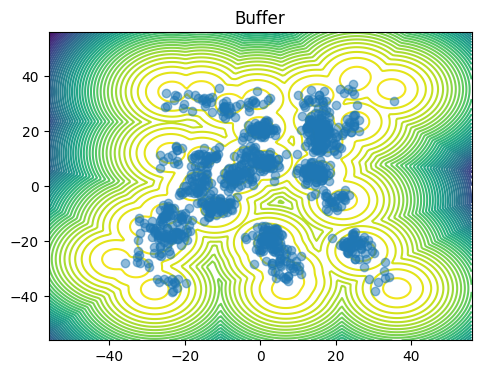

[<Figure size 1200x400 with 1 Axes>]

In [266]:
plot_dataset(samples[-1])

In [250]:
samples

tensor([[[ 1.7914e+06,  1.2763e+06],
         [ 1.0374e+05,  3.0129e+05],
         [-7.4329e+06,  1.1455e+06],
         ...,
         [-2.6728e+06,  8.7338e+06],
         [ 1.1013e+05,  3.3288e+06],
         [-8.4280e+05,  2.3426e+06]],

        [[-1.2029e+15, -8.5700e+14],
         [-6.9659e+13, -2.0231e+14],
         [ 1.9965e+16, -3.0769e+15],
         ...,
         [ 1.7948e+15, -5.8647e+15],
         [-7.3950e+13, -2.2353e+15],
         [ 5.6594e+14, -1.5730e+15]],

        [[ 5.4396e+25,  3.8754e+25],
         [ 3.1500e+24,  9.1485e+24],
         [        nan,         nan],
         ...,
         [        nan,         nan],
         [ 3.3440e+24,  1.0108e+26],
         [-2.5592e+25,  7.1133e+25]],

        ...,

        [[        nan,         nan],
         [        nan,         nan],
         [        nan,         nan],
         ...,
         [        nan,         nan],
         [        nan,         nan],
         [        nan,         nan]],

        [[        nan,         nan

In [72]:
t = torch.linspace(0.0, 1.0, 500)
with torch.no_grad():
    est_samples = torchsde.sdeint(sde, x1_samples, t, method='euler')

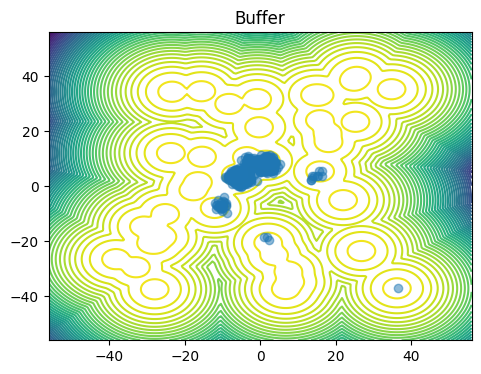

[<Figure size 1200x400 with 1 Axes>]

In [81]:
plot_dataset(torch.cat([est_samples[-1], torch.tensor([[36.5, -37.0]])]))

In [74]:
est_samples.shape

torch.Size([500, 1000, 2])

In [127]:
center = torch.tensor([36.5, -37.0])

t = torch.tensor([1.0])
theta = beta_computer.get_theta(t)
sigma_squared = beta_computer.get_sigma(t).pow(2)

gaussian_center = center * np.exp(-theta * t)
gaussian_var = (sigma_squared / (2 * theta)) * (1 - (-2 * t * theta).exp())

vals = gaussian_center + (np.sqrt(gaussian_var) * torch.randn((2,)))

In [128]:
vals

tensor([0.1487, 0.6933])

In [129]:
gaussian_center

tensor([ 1.3817e-42, -1.3999e-42])

In [130]:
gaussian_var

tensor([1.])